In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import (Activation, Dropout, Flatten, Dense, GlobalMaxPooling2D,
                          BatchNormalization, Input, Conv2D, GlobalAveragePooling2D,concatenate,Concatenate)
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
from keras import metrics
from keras.optimizers import Adam 
from keras import backend as K
import keras
from keras.models import Model

In [ ]:
import pandas as pd 
import matplotlib.pyplot as plt
import skimage.io
from skimage.transform import resize
from imgaug import augmenters as iaa
from tqdm import tqdm
import PIL
from PIL import Image, ImageOps
import cv2
from sklearn.utils import class_weight, shuffle
from keras.losses import binary_crossentropy, categorical_crossentropy
#from keras.applications.resnet50 import preprocess_input
from keras.applications.densenet import DenseNet121,DenseNet169
from keras import optimizers, applications

import keras.backend as K
import tensorflow as tf
from sklearn.metrics import f1_score, fbeta_score, cohen_kappa_score
from keras.utils import Sequence
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import imgaug as ia

WORKERS = 2
CHANNEL = 3

import warnings
warnings.filterwarnings("ignore")
SIZE = 300
NUM_CLASSES = 5

In [ ]:
train_df = pd.read_csv("train.csv")
train_df["id_code"]=train_df["id_code"].apply(lambda x:x+".png")
train_df['diagnosis'] = train_df['diagnosis'].astype(str)
train_df.head()

,id_code,diagnosis
0,000c1434d8d7.png,2
1,001639a390f0.png,4
2,0024cdab0c1e.png,1
3,002c21358ce6.png,0
4,005b95c28852.png,0


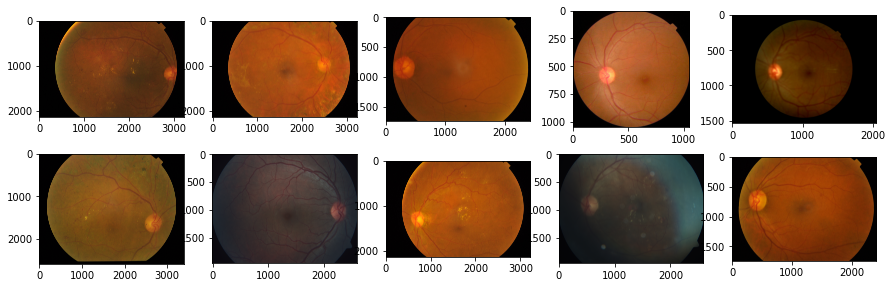

In [ ]:
# Example of images 
img_names = train_df['id_code'][:10]

plt.figure(figsize=[15,15])
i = 1
for img_name in img_names:
    img = cv2.imread("train_images/%s" % img_name)[...,[2, 1, 0]]
    plt.subplot(6, 5, i)
    plt.imshow(img)
    i += 1
plt.show()

In [ ]:
nb_classes = 5
lbls = list(map(str, range(nb_classes)))
batch_size = 32
#img_size = 300 #for resnet
img_size=224 #for densenet
nb_epochs = 5

In [ ]:
lbls

['0', '1', '2', '3', '4']

In [ ]:
%%time

train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        validation_split=0.3)



train_generator=train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory="train_images",
    x_col="id_code",
    y_col="diagnosis",
    batch_size=batch_size,
    shuffle=True,
    class_mode="categorical",
    classes=lbls,
    target_size=(img_size,img_size),
    subset='training')

valid_generator=train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory="train_images",
    x_col="id_code",
    y_col="diagnosis",
    batch_size=batch_size,
    shuffle=True,
    class_mode="categorical", 
    classes=lbls,
    target_size=(img_size,img_size),
    subset='validation')

Found 2564 validated image filenames belonging to 5 classes.
Found 1098 validated image filenames belonging to 5 classes.
CPU times: user 59.8 ms, sys: 10.1 ms, total: 69.9 ms
Wall time: 68.9 ms


In [ ]:
!ls

aptos2019-blindness-detection.zip  sample_submission.csv  train.csv
kaggle.json			   test.csv		  train_images
sample_data			   test_images


In [ ]:
from keras.applications.densenet import DenseNet121
from keras.applications.resnet50 import ResNet50

model=DenseNet121(include_top=False, weights='imagenet', 
                         input_shape=(img_size, img_size, 3))
#model=ResNet50(include_top=False, weights='imagenet', 
#                          input_shape=(img_size, img_size, 3))

#model.save_weights('DenseNet-start.h5')

29089792/29084464 [==============================] - 1s 0us/step


In [ ]:
#model=DenseNet121(include_top=False, weights='imagenet', 
#                          input_shape=(img_size, img_size, 3))
#model.load_weights('DenseNet-start.h5')

In [ ]:
model.trainable = False





In [ ]:
#Adding custom layers 
x = model.output
x = GlobalAveragePooling2D()(x)
#x = Flatten()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
predictions = Dense(nb_classes, activation="softmax")(x)
model_final = Model(input = model.input, output = predictions)

model_final.compile(optimizers.Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
# Callbacks

checkpoint = ModelCheckpoint("model_3.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True, mode='min')
early = EarlyStopping(monitor='val_loss',  patience=9, verbose=1, mode='min')

In [ ]:
%%time
history = model_final.fit_generator(generator=train_generator,                   
                                    steps_per_epoch=100,
                                    validation_data=valid_generator,                    
                                    validation_steps=30,
                                    epochs=nb_epochs,
                                    callbacks = [checkpoint, early],
                                    max_queue_size=16,
                                    workers=2,
                                    use_multiprocessing=True,
                                    verbose=0)


Epoch 00001: val_loss improved from inf to 2.03794, saving model to model_3.h5

Epoch 00002: val_loss did not improve from 2.03794

Epoch 00003: val_loss did not improve from 2.03794

Epoch 00004: val_loss improved from 2.03794 to 0.77719, saving model to model_3.h5

Epoch 00005: val_loss improved from 0.77719 to 0.73988, saving model to model_3.h5
CPU times: user 5min 38s, sys: 43 s, total: 6min 21s
Wall time: 36min 35s


In [ ]:
!ls


aptos2019-blindness-detection.zip  model_1.h5		  test.csv
DenseNet-start.h5		   model_2.h5		  test_images
history.json			   sample_data		  train.csv
kaggle.json			   sample_submission.csv  train_images


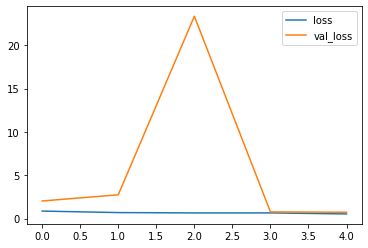

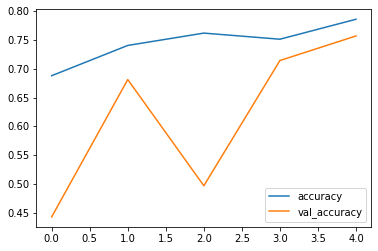

In [ ]:
import json
with open('history.json', 'w') as f:
    json.dump(str(history.history), f)

history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()
history_df[['accuracy', 'val_accuracy']].plot()

In [ ]:
sam_sub_df = pd.read_csv('sample_submission.csv')
sam_sub_df["id_code"]=sam_sub_df["id_code"].apply(lambda x:x+".png")
print(sam_sub_df.shape)
sam_sub_df.head()

(1928, 2)


,id_code,diagnosis
0,0005cfc8afb6.png,0
1,003f0afdcd15.png,0
2,006efc72b638.png,0
3,00836aaacf06.png,0
4,009245722fa4.png,0


In [ ]:
sam_sub_df.diagnosis.value_counts()

0    1928
Name: diagnosis, dtype: int64

In [ ]:
%%time
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(  
        dataframe=sam_sub_df,
        directory = "test_images",    
        x_col="id_code",
        target_size = (img_size,img_size),
        batch_size = 1,
        shuffle = False,
        class_mode = None
        )

Found 1928 validated image filenames.
CPU times: user 16.5 ms, sys: 15.2 ms, total: 31.6 ms
Wall time: 52.9 ms


In [ ]:
%%time
test_generator.reset()
predict=model_final.predict_generator(test_generator, steps = len(test_generator.filenames))

CPU times: user 3min 8s, sys: 3.31 s, total: 3min 11s
Wall time: 1min 48s


In [ ]:
import numpy as np 
y_tst=pd.Series(np.argmax(predict,axis=1))
y_tst

0       2
1       2
2       2
3       2
4       2
       ..
1923    0
1924    1
1925    2
1926    2
1927    2
Length: 1928, dtype: int64

In [ ]:
y_tst.value_counts()

2    1242
0     407
1     257
3      16
4       6
dtype: int64

In [ ]:
import numpy as np
filenames=test_generator.filenames
results=pd.DataFrame({"id_code":filenames,
                      "diagnosis":np.argmax(predict,axis=1)})
results['id_code'] = results['id_code'].map(lambda x: str(x)[:-4])
results.to_csv("submission.csv",index=False)

In [ ]:
%%time
test_generator = test_datagen.flow_from_dataframe(  
        dataframe=sam_sub_df,
        directory = "test_images",    
        x_col="id_code",
        target_size = (img_size,img_size),
        batch_size = 1,
        shuffle = False,
        class_mode = None
        )